In [86]:
from urllib import request
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import json 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud

In [87]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.text import Text
from nltk import FreqDist
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree

In [88]:
from zigzag import peak_valley_pivots
from segments import Segments

In [89]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/rita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [90]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/rita/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [91]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [92]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/rita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [93]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/rita/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [94]:
nltk.download('words')

[nltk_data] Downloading package words to /home/rita/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# 1) Get FOMC statements from website

In [95]:
#function to get json of FOMC statements
def statements(url_string,filter_string):
    url = url_string
    request_site = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    webpage = urlopen(request_site).read()
    y = json.loads(webpage)
    body = y['mtgitems']
    statements = list(filter(lambda x: x['type'] == filter_string,body))
    return statements

In [96]:
#get only statements (type = "St")
statements_hist = statements('https://www.federalreserve.gov/monetarypolicy/materials/assets/final-hist.json','St')
statements_recent = statements('https://www.federalreserve.gov/monetarypolicy/materials/assets/final-recent.json', 'St')

In [97]:
#from json get only date and url
statements_hist_dict = [{'date': datetime.strptime(x['d'],'%Y-%m-%d'), 'url': 'https://www.federalreserve.gov' + x['url']} for x in statements_hist]
statements_recent_dict = [{'date': datetime.strptime(x['d'],'%Y-%m-%d'), 'url': 'https://www.federalreserve.gov' + x['files'][0]['url']} for x in statements_recent]
statements_dict = statements_recent_dict + statements_hist_dict

In [98]:
statements_dict

[{'date': datetime.datetime(2022, 12, 14, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20221214a.htm'},
 {'date': datetime.datetime(2022, 11, 2, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20221102a.htm'},
 {'date': datetime.datetime(2022, 9, 21, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220921a.htm'},
 {'date': datetime.datetime(2022, 7, 27, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220727a.htm'},
 {'date': datetime.datetime(2022, 6, 15, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220615a.htm'},
 {'date': datetime.datetime(2022, 5, 4, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220504a.htm'},
 {'date': datetime.datetime(2022, 3, 16, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220316a.htm'},
 {'date': datetime.datetime

In [99]:
# TO DO: earlier statements
#for statements after 06 only
statements_dict_06 = list(filter(lambda x: x['date'].year >= 2006,statements_dict))

for st in statements_dict_06:
    #crawl each link in dictionary
    url = st['url']
    request_site = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    webpage = urlopen(request_site).read()

    parsed_html = BeautifulSoup(webpage, "html.parser")
    text = parsed_html.body.find(attrs={'class':'col-xs-12 col-sm-8 col-md-8'})

    paragraphs = text.find_all('p')    
    paragraphs = [pa.text for pa in paragraphs]
    
    #find the voting paragraph (key words are 'voting for' and 'voting against')
    voting_for = [i for i, p in enumerate(paragraphs) if 'Voting for' in p]
    voting_against = [i for i, p in enumerate(paragraphs) if 'Voting against' in p]

    #if there is no paragraph about voting: assume that the statement was not a regular monetary policy decision. drop it later
    #else separate text before voting (voting paragraph is the last relevant one) and voting paragraph and drop text after voting
    if len(voting_for)==0 and len(voting_against)==0:
        paragraph = ''
        voting_p = ''
    #if no one voted against decision
    elif len(voting_against)==0:
        paragraph = ' '.join(paragraphs[0:voting_for[0]])
        voting_p = paragraphs[voting_for[0]]
    #if voting is in one paragraph
    elif voting_for[0] == voting_against[0]:
        paragraph = ' '.join(paragraphs[0:voting_for[0]])
        voting_p = paragraphs[voting_for[0]]
    #if voting is two different paragraphs
    elif voting_for[0] < voting_against[0]:
        paragraph = ' '.join(paragraphs[0:voting_for[0]])
        voting_p = ' '.join(paragraphs[voting_for[0]:(voting_against[0]+1)])
    
    #replace cases with space '\r\n' '\xa0' 
    #remove multiple spaces
    paragraph = re.sub('\xa0', ' ', paragraph)
    paragraph = re.sub('\r\n', ' ', paragraph)
    paragraph = re.sub(' +', ' ', paragraph)

    voting_p = re.sub('\xa0', ' ', voting_p)
    voting_p = re.sub('\r\n', ' ', voting_p)
    voting_p = re.sub(' +', ' ', voting_p)    
    
    #add text and voting paragraph to dictionary
    st['text'] = paragraph
    st['voting'] = voting_p
    
    print(st['date'])

2022-12-14 00:00:00
2022-11-02 00:00:00
2022-09-21 00:00:00
2022-07-27 00:00:00
2022-06-15 00:00:00
2022-05-04 00:00:00
2022-03-16 00:00:00
2022-01-26 00:00:00
2021-12-15 00:00:00
2021-11-03 00:00:00
2021-09-22 00:00:00
2021-07-28 00:00:00
2021-06-16 00:00:00
2021-04-28 00:00:00
2021-03-17 00:00:00
2021-01-27 00:00:00
2020-12-16 00:00:00
2020-11-05 00:00:00
2020-09-16 00:00:00
2020-07-29 00:00:00
2020-06-10 00:00:00
2020-04-29 00:00:00
2020-03-23 00:00:00
2020-03-15 00:00:00
2020-03-03 00:00:00
2020-01-29 00:00:00
2019-01-30 00:00:00
2019-03-20 00:00:00
2019-05-01 00:00:00
2019-06-19 00:00:00
2019-07-31 00:00:00
2019-09-18 00:00:00
2019-10-04 00:00:00
2019-10-30 00:00:00
2019-12-11 00:00:00
2018-01-31 00:00:00
2018-03-21 00:00:00
2018-05-02 00:00:00
2018-06-13 00:00:00
2018-08-01 00:00:00
2018-09-26 00:00:00
2018-11-08 00:00:00
2018-12-19 00:00:00
2017-02-01 00:00:00
2017-03-15 00:00:00
2017-05-03 00:00:00
2017-06-14 00:00:00
2017-07-26 00:00:00
2017-09-20 00:00:00
2017-11-01 00:00:00


In [100]:
# delete statements that had no voting paragraph
statements_dict_06 = [item for item in statements_dict_06 if item['text'] !='']

In [101]:
statements_dict_06

[{'date': datetime.datetime(2022, 12, 14, 0, 0),
  'url': 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20221214a.htm',
  'text': "Recent indicators point to modest growth in spending and production. Job gains have been robust in recent months, and the unemployment rate has remained low. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher food and energy prices, and broader price pressures. Russia's war against Ukraine is causing tremendous human and economic hardship. The war and related events are contributing to upward pressure on inflation and are weighing on global economic activity. The Committee is highly attentive to inflation risks. The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to raise the target range for the federal funds rate to 4-1/4 to 4-1/2 percent. The Committee anticipates that ongoing incre

# 2) Analyse FOMC statmenets

In [103]:
# extract some information such as text length, chair name and voting behaviour

# pattern to detect name of Chair
pattern_chair = re.compile(r"(?P<fullname>\w+\s(\w\.\s)?\w+)\s*\W\s*(Chair)")

# pattern to find all names
pattern_name = re.compile(r"([A-Z](?!ice Chair)\w+\s(\w\.\s)?[A-Z])")

for i in statements_dict_06:
    # length of paragraph (word count including stop words)
    text = i['text']
    text_len = len(text.split())
    i['paragraph_length'] = text_len
    
    # find the Chair person
    vote = i['voting']
    i['Chair'] = re.search(pattern_chair, vote).group('fullname')
    
    # split voting paragraph to find number of votes for and against decision
    vote_s = vote.split('Voting against')
    
    i['votes_for'] = len(re.findall(pattern_name, vote_s[0]))
    
    if len(vote_s) > 1:
        i['votes_against'] = len(re.findall(pattern_name, vote_s[1]))
    else:
        i['votes_against'] = 0

In [104]:
#test nltk name entity recognition
text = statements_dict_06[100]['voting']

nltk_results = ne_chunk(pos_tag(word_tokenize(text)))
for nltk_result in nltk_results:
    if type(nltk_result) == Tree:
        name = ''
        for nltk_result_leaf in nltk_result.leaves():
            name += nltk_result_leaf[0] + ' '
        print ('Type: ', nltk_result.label(), 'Name: ', name)

Type:  ORGANIZATION Name:  FOMC 
Type:  PERSON Name:  Ben S. Bernanke 
Type:  PERSON Name:  Chairman 
Type:  PERSON Name:  William C. Dudley 
Type:  PERSON Name:  James Bullard 
Type:  PERSON Name:  Elizabeth A. Duke 
Type:  PERSON Name:  Donald L. Kohn 
Type:  PERSON Name:  Sandra Pianalto 
Type:  PERSON Name:  Eric S. Rosengren 
Type:  PERSON Name:  Daniel K. Tarullo 
Type:  PERSON Name:  Kevin M. Warsh 
Type:  PERSON Name:  Thomas M. Hoenig 
Type:  ORGANIZATION Name:  Committee 


In [105]:
#convert dictionary to sorted data frame by date
statements_df = pd.DataFrame(statements_dict_06)
statements_df.set_index('date',inplace=True)
statements_df = statements_df.sort_index()
statements_df.tail(10)

,url,text,voting,paragraph_length,Chair,votes_for,votes_against
date,,,,,,,
2021-11-03,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve is committed to using its ...,Voting for the monetary policy action were Jer...,571,Jerome H. Powell,11,0
2021-12-15,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve is committed to using its ...,Voting for the monetary policy action were Jer...,478,Jerome H. Powell,11,0
2022-01-26,https://www.federalreserve.gov/newsevents/pres...,Indicators of economic activity and employment...,Voting for the monetary policy action were Jer...,385,Jerome H. Powell,10,0
2022-03-16,https://www.federalreserve.gov/newsevents/pres...,Indicators of economic activity and employment...,Voting for the monetary policy action were Jer...,274,Jerome H. Powell,8,2
2022-05-04,https://www.federalreserve.gov/newsevents/pres...,Although overall economic activity edged down ...,Voting for the monetary policy action were Jer...,321,Jerome H. Powell,10,0
2022-06-15,https://www.federalreserve.gov/newsevents/pres...,Overall economic activity appears to have pick...,Voting for the monetary policy action were Jer...,287,Jerome H. Powell,10,2
2022-07-27,https://www.federalreserve.gov/newsevents/pres...,Recent indicators of spending and production h...,Voting for the monetary policy action were Jer...,268,Jerome H. Powell,12,0
2022-09-21,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,269,Jerome H. Powell,12,0
2022-11-02,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,330,Jerome H. Powell,12,0


## 2a) statement length

In [106]:
# function to create bar plot by chair

#get uniqe names
names = list(set(list(statements_df['Chair'])))
#choose a color scale
colors = list(mcolors.TABLEAU_COLORS.values())

#write a list with colors for each observation
colors_l = list(statements_df['Chair'])
for i in range(0,len(names)):
    colors_l = [c.replace(names[i], colors[i]) for c in colors_l]

#plot a series from the statements data frame by chair
def bar_plot_by_chair(series, title):
    plt.figure(figsize=(10, 3))

    p = statements_df.index.to_period('M')
    plt.bar(list(range(0,len(statements_df))), series, color=colors_l)
    plt.xticks(list(range(0,len(statements_df)))[0::16], p[0::16])


    labels = names
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i, n in enumerate(names)]
    plt.legend(handles, labels)
    plt.title(title)

    return plt

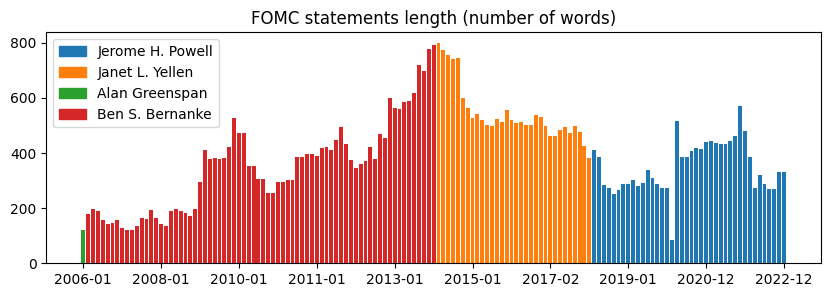

In [107]:
bar_plot_by_chair(statements_df['paragraph_length'], 'FOMC statements length (number of words)').show()

In [108]:
import warnings
warnings.filterwarnings('ignore')

# in number of sentences
statements_df['sentences'] = 0
for r, s in enumerate(statements_df['text']):
    statements_df['sentences'][r] = len(sent_tokenize(s))

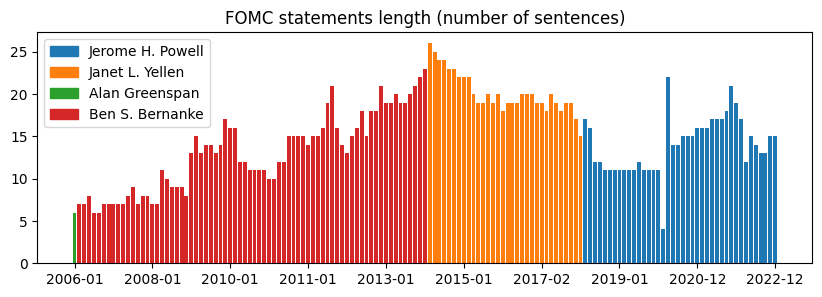

In [109]:
bar_plot_by_chair(statements_df['sentences'], 'FOMC statements length (number of sentences)').show()

In [110]:
# average number of words per sentence
statements_df['words_per_sentence'] = statements_df['paragraph_length']/statements_df['sentences']

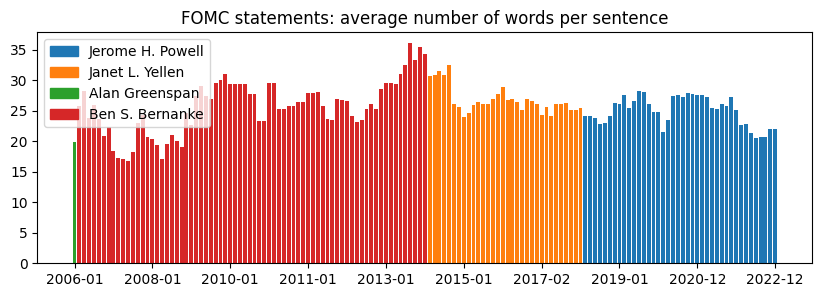

In [111]:
bar_plot_by_chair(statements_df['words_per_sentence'], 'FOMC statements: average number of words per sentence').show()

In [112]:
statements_df.groupby('Chair')['words_per_sentence'].mean()

Chair
Alan Greenspan      19.833333
Ben S. Bernanke     25.680722
Janet L. Yellen     26.810336
Jerome H. Powell    24.961301
Name: words_per_sentence, dtype: float64

Ben Bernanke's statements not only got longer over time but the sentences also seem to have become more complicated (more words per sentence). On average, Janet Yellen formed the longest sentences.

## 2b) disagreement

In [113]:
#calculate number of FOMC members who disagreed with decision vs. number of voters
statements_df['disagreement_ratio'] = statements_df['votes_against']/(statements_df['votes_for']+statements_df['votes_against'])

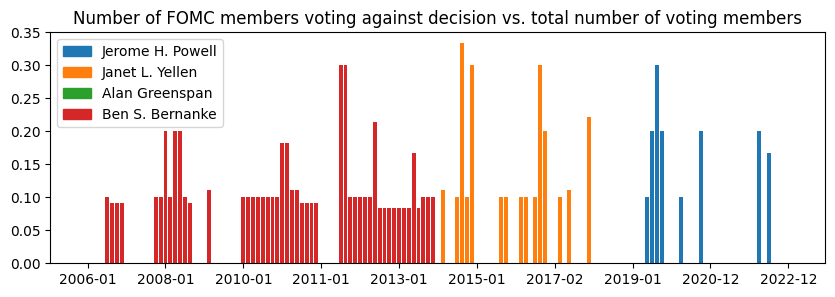

In [114]:
bar_plot_by_chair(statements_df['disagreement_ratio'], 'Number of FOMC members voting against decision vs. total number of voting members').show()

## 2c) frequent words 

In [115]:
# filter out stop words
stop_words = set(stopwords.words("english"))
stop_words.add('today')
tokenizer = nltk.RegexpTokenizer(r"\w+")

# also delete reference of the FOMC to itself 
#(further potential candidates for deleltion "decided", "recent indicators")
more_stop_words = ['federal open market committee ', ' committee', 'federal funds rate']

In [116]:
#function to return a list of tockens without stopwords and phrases
def filter_text(text):
    #lowercasing
    for w in text:
        text = text.replace(w,w.lower())
        
    #delete phrases    
    for w in more_stop_words:
        text = text.replace(w,'')

    #remove numbers
    text = re.sub(r'\d+', '', text)

    #delete punctuation and tokenize statements
    statement_tokens = tokenizer.tokenize(text)
    
    #get a list of words that are not stopwords
    filtered_list = []

    for word in statement_tokens:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    
    return filtered_list

In [117]:
#tocknized and filtered list for all statements (plust stemmed and leammatized)
statements_df['filtered_list'] = ""
statements_df['stemmed_list'] = ""
statements_df['lemmatized_list'] = ""
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for r, t in enumerate(statements_df['text']):
    statements_df['filtered_list'][r] = filter_text(t)
    statements_df['stemmed_list'][r] = [stemmer.stem(word) for word in statements_df['filtered_list'][r]]
    statements_df['lemmatized_list'][r] = [lemmatizer.lemmatize(word) for word in statements_df['filtered_list'][r]]

In [118]:
statements_df.tail(3)

,url,text,voting,paragraph_length,Chair,votes_for,votes_against,sentences,words_per_sentence,disagreement_ratio,filtered_list,stemmed_list,lemmatized_list
date,,,,,,,,,,,,,
2022-09-21,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,269,Jerome H. Powell,12,0,13,20.692308,0.0,"[recent, indicators, point, modest, growth, sp...","[recent, indic, point, modest, growth, spend, ...","[recent, indicator, point, modest, growth, spe..."
2022-11-02,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,330,Jerome H. Powell,12,0,15,22.000000,0.0,"[recent, indicators, point, modest, growth, sp...","[recent, indic, point, modest, growth, spend, ...","[recent, indicator, point, modest, growth, spe..."
2022-12-14,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,330,Jerome H. Powell,12,0,15,22.000000,0.0,"[recent, indicators, point, modest, growth, sp...","[recent, indic, point, modest, growth, spend, ...","[recent, indicator, point, modest, growth, spe..."


In [119]:
#join the words accross all statements into single list to generate wordcloud
all_statements = statements_df['filtered_list'].sum()
all_statements_stemmed = statements_df['stemmed_list'].sum()
all_statements_lemmatized = statements_df['lemmatized_list'].sum()

(-0.5, 399.5, 199.5, -0.5)

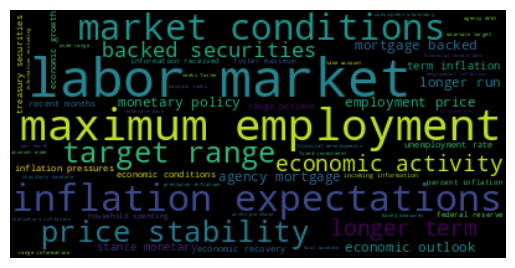

In [120]:
#wordcloud overall
wordcloud = WordCloud().generate(' '.join(all_statements))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

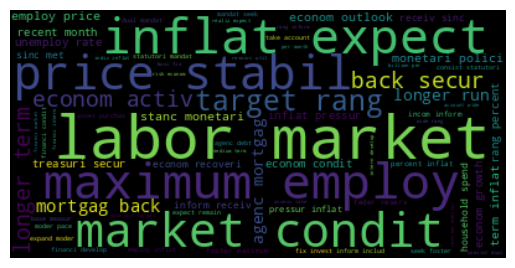

In [121]:
#Stemmed word cloud
wordcloud = WordCloud().generate(' '.join(all_statements_stemmed))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

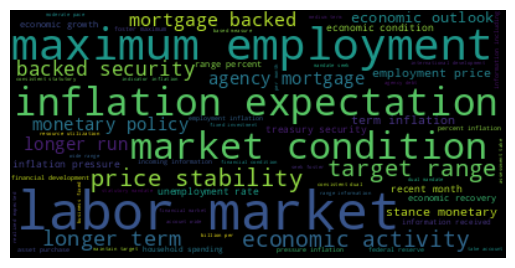

In [122]:
#lemmatized word cloud
wordcloud = WordCloud().generate(' '.join(all_statements_lemmatized))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [123]:
#colloction (wordcloud already takes care of this)
textList = Text(all_statements_lemmatized)
textList.collocations()

labor market; maximum employment; price stability; target range;
mortgage backed; backed security; stance monetary; agency mortgage;
inflation expectation; economic activity; longer term; monetary
policy; market condition; longer run; federal reserve; since met;
received since; unemployment rate; household spending; information
received


In [124]:
#frequency distributions
frequency_distribution = FreqDist(all_statements)
frequency_distribution.most_common(10)

[('inflation', 1155),
 ('economic', 751),
 ('percent', 481),
 ('market', 479),
 ('conditions', 453),
 ('labor', 408),
 ('securities', 394),
 ('policy', 374),
 ('longer', 361),
 ('term', 338)]

In [125]:
frequency_distribution = FreqDist(all_statements_stemmed)
frequency_distribution.most_common(10)

[('inflat', 1155),
 ('econom', 751),
 ('market', 593),
 ('expect', 544),
 ('continu', 495),
 ('percent', 481),
 ('condit', 453),
 ('remain', 452),
 ('labor', 408),
 ('secur', 394)]

In [126]:
frequency_distribution = FreqDist(all_statements_lemmatized)
frequency_distribution.most_common(10)

[('inflation', 1155),
 ('economic', 751),
 ('market', 593),
 ('percent', 481),
 ('condition', 453),
 ('labor', 408),
 ('security', 394),
 ('price', 383),
 ('policy', 379),
 ('longer', 361)]

In [127]:
#concordance
textList = Text(all_statements)
textList.concordance('inflation')

Displaying 25 of 1155 matches:
onomic activity appears solid core inflation stayed relatively low recent month
vely low recent months longer term inflation expectations remain contained neve
evated energy prices potential add inflation pressures judges policy firming ma
odities appears modest effect core inflation ongoing productivity gains helped 
hold growth unit labor costs check inflation expectations remain contained stil
s energy commodities potential add inflation pressures judges policy firming ma
odities appears modest effect core inflation ongoing productivity gains helped 
hold growth unit labor costs check inflation expectations remain contained stil
s energy commodities potential add inflation pressures judges policy firming ma
icy firming may yet needed address inflation risks emphasizes extent timing fir
 rates energy prices readings core inflation elevated recent months ongoing pro
y gains held rise unit labor costs inflation expectations remain contained howe
ergy comm

In [128]:
#Get a list of words per Chair
statements_by_chair = statements_df.groupby(['Chair'])['filtered_list'].sum()

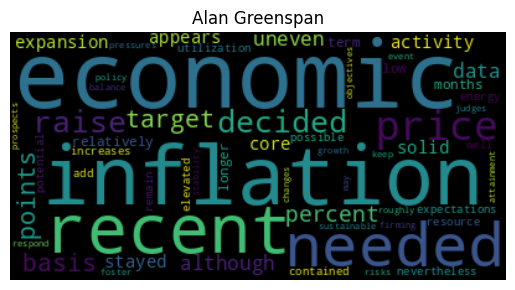

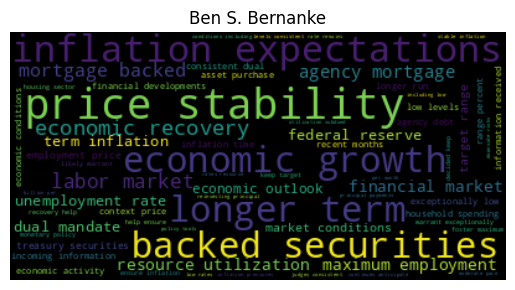

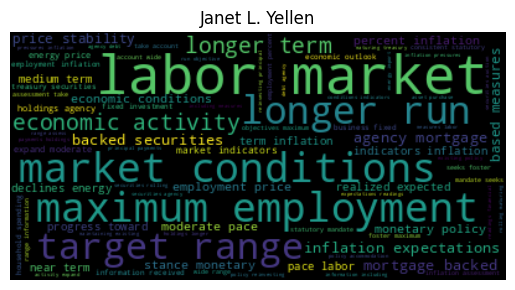

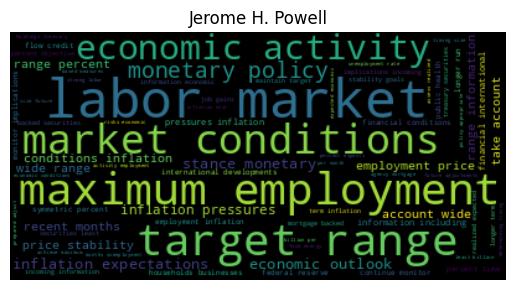

In [129]:
#Generate wordcloud per Chair
for i,c in enumerate(statements_by_chair):
    wordcloud = WordCloud().generate(' '.join(c))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(statements_by_chair.index[i])
    
    plt.show()

## 2d) Sentiment

In [130]:
#load the Loughran and McDonald dictionary and extract negative, positive and uncertain words
words_loughran = pd.read_csv('data/Loughran-McDonald_MasterDictionary_1993-2021.csv')
words_negative = [words_loughran['Word'][i].lower() for i in range(0,len(words_loughran)) if words_loughran['Negative'][i]>0]
words_positive = [words_loughran['Word'][i].lower() for i in range(0,len(words_loughran)) if words_loughran['Positive'][i]>0]
words_uncertain = [words_loughran['Word'][i].lower() for i in range(0,len(words_loughran)) if words_loughran['Uncertainty'][i]>0]

In [131]:
words_negative

['abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandonments',
 'abandons',
 'abdicated',
 'abdicates',
 'abdicating',
 'abdication',
 'abdications',
 'aberrant',
 'aberration',
 'aberrational',
 'aberrations',
 'abetting',
 'abnormal',
 'abnormalities',
 'abnormality',
 'abnormally',
 'abolish',
 'abolished',
 'abolishes',
 'abolishing',
 'abrogate',
 'abrogated',
 'abrogates',
 'abrogating',
 'abrogation',
 'abrogations',
 'abrupt',
 'abruptly',
 'abruptness',
 'absence',
 'absences',
 'absenteeism',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'abusively',
 'abusiveness',
 'accident',
 'accidental',
 'accidentally',
 'accidents',
 'accusation',
 'accusations',
 'accuse',
 'accused',
 'accuses',
 'accusing',
 'acquiesce',
 'acquiesced',
 'acquiesces',
 'acquiescing',
 'acquit',
 'acquits',
 'acquittal',
 'acquittals',
 'acquitted',
 'acquitting',
 'adulterate',
 'adulterated',
 'adulterating',
 'adulteration',
 'adulterations',
 'adversarial',
 'adversaries',
 

In [132]:
words_positive

['able',
 'abundance',
 'abundant',
 'acclaimed',
 'accomplish',
 'accomplished',
 'accomplishes',
 'accomplishing',
 'accomplishment',
 'accomplishments',
 'achieve',
 'achieved',
 'achievement',
 'achievements',
 'achieves',
 'achieving',
 'adequately',
 'advancement',
 'advancements',
 'advances',
 'advancing',
 'advantage',
 'advantaged',
 'advantageous',
 'advantageously',
 'advantages',
 'alliance',
 'alliances',
 'assure',
 'assured',
 'assures',
 'assuring',
 'attain',
 'attained',
 'attaining',
 'attainment',
 'attainments',
 'attains',
 'attractive',
 'attractiveness',
 'beautiful',
 'beautifully',
 'beneficially',
 'benefited',
 'benefiting',
 'benefitted',
 'benefitting',
 'best',
 'better',
 'bolstered',
 'bolstering',
 'bolsters',
 'boom',
 'booming',
 'boost',
 'boosted',
 'breakthrough',
 'breakthroughs',
 'brilliant',
 'charitable',
 'collaborate',
 'collaborated',
 'collaborates',
 'collaborating',
 'collaboration',
 'collaborations',
 'collaborative',
 'collaborator'

In [133]:
words_uncertain

['abeyance',
 'abeyances',
 'almost',
 'alteration',
 'alterations',
 'ambiguities',
 'ambiguity',
 'ambiguous',
 'anomalies',
 'anomalous',
 'anomalously',
 'anomaly',
 'anticipate',
 'anticipated',
 'anticipates',
 'anticipating',
 'anticipation',
 'anticipations',
 'apparent',
 'apparently',
 'appear',
 'appeared',
 'appearing',
 'appears',
 'approximate',
 'approximated',
 'approximately',
 'approximates',
 'approximating',
 'approximation',
 'approximations',
 'arbitrarily',
 'arbitrariness',
 'arbitrary',
 'assume',
 'assumed',
 'assumes',
 'assuming',
 'assumption',
 'assumptions',
 'believe',
 'believed',
 'believes',
 'believing',
 'cautious',
 'cautiously',
 'cautiousness',
 'clarification',
 'clarifications',
 'conceivable',
 'conceivably',
 'conditional',
 'conditionally',
 'confuses',
 'confusing',
 'confusingly',
 'confusion',
 'contingencies',
 'contingency',
 'contingent',
 'contingently',
 'contingents',
 'could',
 'crossroad',
 'crossroads',
 'depend',
 'depended',
 '

In [134]:
statements_df['positive_count'] = 0
statements_df['negative_count'] = 0
statements_df['uncertain_count'] = 0
statements_df['filtered_count'] = 0
statements_df['positive_words'] = ""
statements_df['negative_words'] = ""
statements_df['uncertain_words'] = ""

#count number of positive, negative and uncertain words
for r, p in enumerate(statements_df['text']):
    pos_count = 0
    neg_count = 0
    unc_count = 0
 
    pos_words = []
    neg_words = []
    unc_words = []
    
    filtered_list = filter_text(p)
    word_count = len(filtered_list)
    
    for i in range(0, word_count):
        if filtered_list[i] in words_negative:
            neg_count += 1
            neg_words.append(filtered_list[i])
        if filtered_list[i] in words_positive:
            pos_count += 1
            pos_words.append(filtered_list[i])
        if filtered_list[i] in words_uncertain:
            unc_count += 1
            unc_words.append(filtered_list[i])
    
    statements_df['positive_count'][r] = pos_count
    statements_df['negative_count'][r] = neg_count
    statements_df['uncertain_count'][r] = unc_count
    statements_df['positive_words'][r] = pos_words
    statements_df['negative_words'][r] = neg_words
    statements_df['uncertain_words'][r] = unc_words
    statements_df['filtered_count'][r] = word_count

In [135]:
statements_df.tail(3)

,url,text,voting,paragraph_length,Chair,votes_for,votes_against,sentences,words_per_sentence,disagreement_ratio,filtered_list,stemmed_list,lemmatized_list,positive_count,negative_count,uncertain_count,filtered_count,positive_words,negative_words,uncertain_words
date,,,,,,,,,,,,,,,,,,,,
2022-09-21,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,269,Jerome H. Powell,12,0,13,20.692308,0.0,"[recent, indicators, point, modest, growth, sp...","[recent, indic, point, modest, growth, spend, ...","[recent, indicator, point, modest, growth, spe...",4,4,5,151,"[gains, tremendous, achieve, attainment]","[unemployment, imbalances, hardship, impede]","[risks, anticipates, may, risks, could]"
2022-11-02,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,330,Jerome H. Powell,12,0,15,22.000000,0.0,"[recent, indicators, point, modest, growth, sp...","[recent, indic, point, modest, growth, spend, ...","[recent, indicator, point, modest, growth, spe...",5,6,5,184,"[gains, tremendous, achieve, attain, attainment]","[unemployment, imbalances, hardship, tightenin...","[risks, anticipates, may, risks, could]"
2022-12-14,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,330,Jerome H. Powell,12,0,15,22.000000,0.0,"[recent, indicators, point, modest, growth, sp...","[recent, indic, point, modest, growth, spend, ...","[recent, indicator, point, modest, growth, spe...",5,6,5,183,"[gains, tremendous, achieve, attain, attainment]","[unemployment, imbalances, hardship, tightenin...","[risks, anticipates, may, risks, could]"


In [136]:
#calculate sentiment ratios (word counts per total number of words)
statements_df['net_sentiment'] = statements_df['positive_count'] - statements_df['negative_count']
statements_df['neg_sentiment'] = statements_df['negative_count']/ statements_df['filtered_count']
statements_df['pos_sentiment'] = statements_df['positive_count']/ statements_df['filtered_count']
statements_df['sentiment'] = statements_df['net_sentiment']/ statements_df['filtered_count']
statements_df['uncertainty'] = statements_df['uncertain_count']/statements_df['filtered_count']

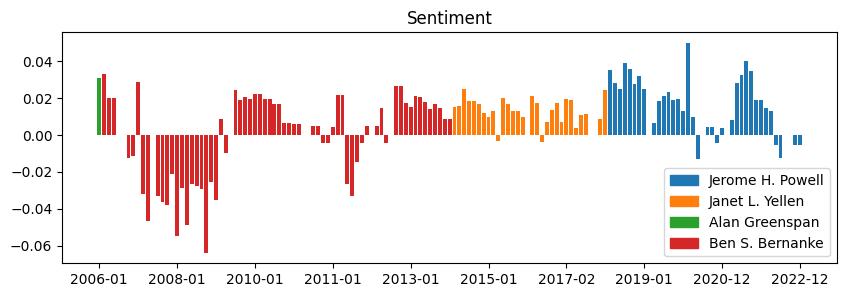

In [137]:
bar_plot_by_chair(statements_df['sentiment'], 'Sentiment').show()

In [138]:
statements_df['sentiment'].idxmax()

Timestamp('2020-03-03 00:00:00')

In [143]:
statements_df.loc[statements_df['sentiment'].idxmax()]

url                   https://www.federalreserve.gov/newsevents/pres...
text                  The fundamentals of the U.S. economy remain st...
voting                Voting for the monetary policy action were Jer...
paragraph_length                                                     86
Chair                                                  Jerome H. Powell
votes_for                                                            10
votes_against                                                         0
sentences                                                             4
words_per_sentence                                                 21.5
disagreement_ratio                                                  0.0
filtered_list         [fundamentals, u, economy, remain, strong, how...
stemmed_list          [fundament, u, economi, remain, strong, howev,...
lemmatized_list       [fundamental, u, economy, remain, strong, howe...
positive_count                                                  

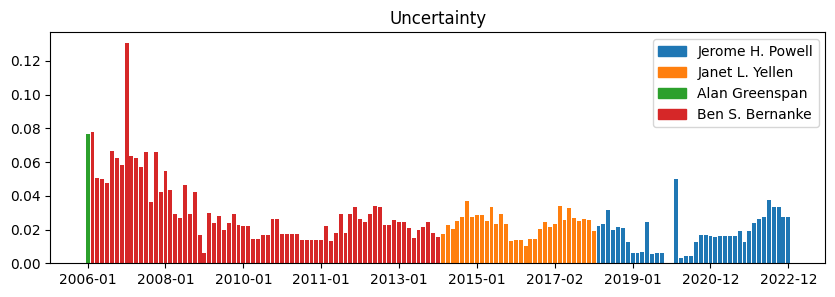

In [144]:
bar_plot_by_chair(statements_df['uncertainty'], 'Uncertainty').show()

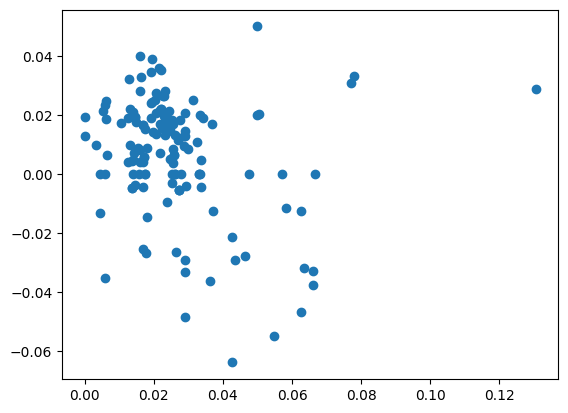

In [145]:
#correlation between sentiment and uncertainty
plt.scatter(statements_df['uncertainty'],statements_df['sentiment'])

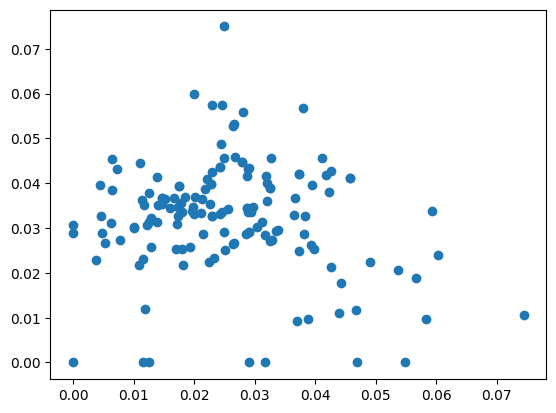

In [146]:
#correlation between negative and positive sentiment
plt.scatter(statements_df['neg_sentiment'],statements_df['pos_sentiment'])

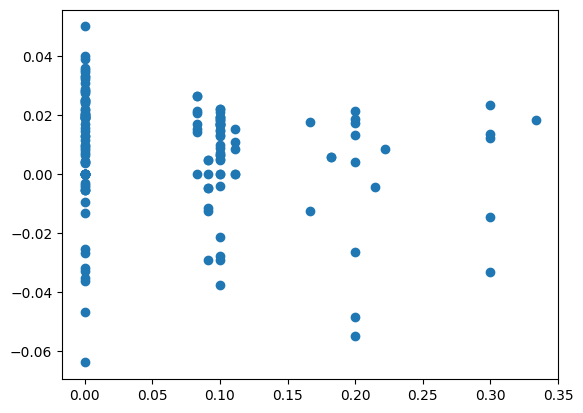

In [147]:
#correlation between disagreement ratio and sentiment
plt.scatter(statements_df['disagreement_ratio'],statements_df['sentiment'])

In [148]:
#TO DO 
#Sentiment analysis: https://realpython.com/python-nltk-sentiment-analysis/
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(statements_df['text'][0])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rita/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.051, 'neu': 0.867, 'pos': 0.083, 'compound': 0.4767}

# 3) Financial data

In [149]:
# import the data
financials = pd.read_excel('data/IR_data.xlsx', header=3, index_col=0)

In [150]:
financials.tail(10)

,Dow Jones Industrial Average,S&P 500 INDEX,NASDAQ Composite Index,"United States, Policy Rates, Target Rates, Federal Funds Target Rate, Mid-point","United States, Policy Rates, Target Rates, Federal Funds Target Rate, Upper Band","United States, Policy Rates, Target Rates, Federal Funds Target Rate, Lower Band",US Generic Govt 10 Yr
2022-12-05,33947.10,3998.84,11239.94,3.875,4.0,3.75,3.5736
2022-12-06,33596.34,3941.26,11014.89,3.875,4.0,3.75,3.5314
2022-12-07,33597.92,3933.92,10958.55,3.875,4.0,3.75,3.4169
2022-12-08,33781.48,3963.51,11082.00,3.875,4.0,3.75,3.4819
2022-12-09,33476.46,3934.38,11004.62,3.875,4.0,3.75,3.5783
2022-12-12,34005.04,3990.56,11143.74,3.875,4.0,3.75,3.6113
2022-12-13,34108.64,4019.65,11256.81,3.875,4.0,3.75,3.5012
2022-12-14,33966.35,3995.32,11170.89,3.875,4.0,3.75,3.4774
2022-12-15,33202.22,3895.75,10810.53,4.375,4.5,4.25,3.4463
2022-12-16,32920.46,3852.36,10705.41,4.375,4.5,4.25,3.4822


## 3a) extract interest rate decisions on statement dates

In [151]:
#extract the change in interest rates at each monetary policy decision
statements_df['rate_change'] = 0

for dates in statements_df.index:
    tmp = financials[financials.index >= dates]
    end = tmp['United States, Policy Rates, Target Rates, Federal Funds Target Rate, Upper Band'][1]
    start = tmp['United States, Policy Rates, Target Rates, Federal Funds Target Rate, Upper Band'][0]
    statements_df['rate_change'][dates] = end - start

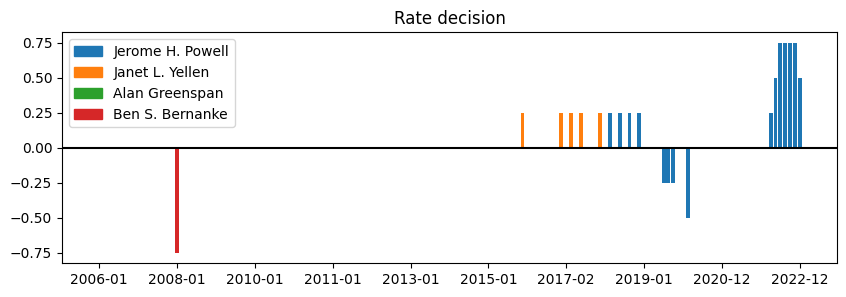

In [152]:
plt = bar_plot_by_chair(statements_df['rate_change'], 'Rate decision')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.show()

## 3b) extract equity market trends

In [153]:
#alternative tried but abandoned (does not produce same number of local maxima and minima)

# from scipy.signal import argrelextrema
# from segments import Segments


# n = 50  # number of points to be checked before and after

# # Find local peaks
# financials = financials['2000-01-01':]

# financials['max'] = financials.iloc[argrelextrema(financials['S&P 500 INDEX'].values, np.less_equal,
#                     order=n)[0]]['S&P 500 INDEX']
# financials['min'] = financials.iloc[argrelextrema(financials['S&P 500 INDEX'].values, np.greater_equal,
#                     order=n)[0]]['S&P 500 INDEX']

# # Plot results

# plt.scatter(financials.index, financials['min'], c='r')
# plt.scatter(financials.index, financials['max'], c='g')
# plt.plot(financials.index, financials['S&P 500 INDEX'])
# plt.show()

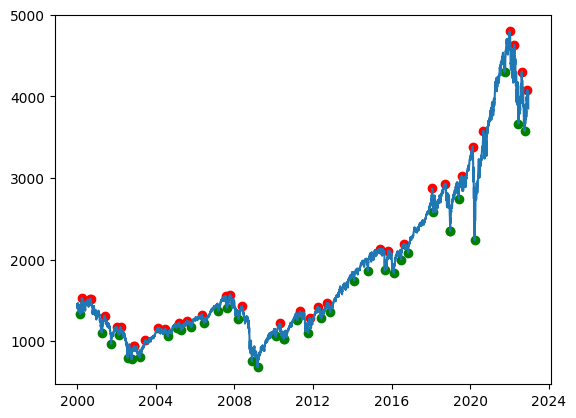

In [154]:
#function to plot zig zag pattern over equity index
def plot_pivots(X, pivots):
    plt.figure(figsize=(10, 3))
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')

In [155]:
#get Dow Jones index
c0 = financials.index.to_series().between('2006-01-01', '2022-12-16')
sdf = financials[c0]
sdf = sdf["Dow Jones Industrial Average"]

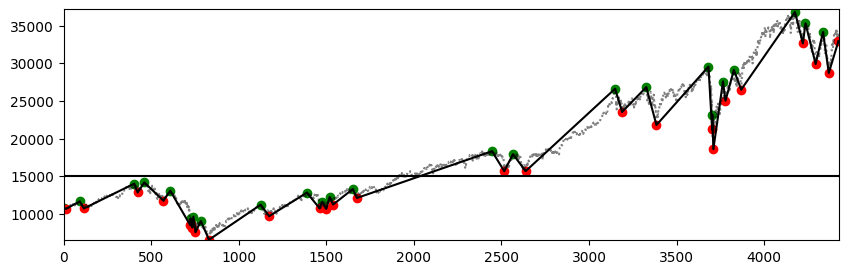

In [156]:
#find trend pattern (parameters set by "expert judgement")
pivots = peak_valley_pivots(sdf, 0.08, -0.08)
plot_pivots(sdf, pivots)
plt.axhline(y =15000, color = 'black', linestyle = '-')

In [157]:
#find segment parameters of trend pattern
segments = Segments()
segments.calculate_segments(sdf, pivots)

In [158]:
segments.segments.head()

,date_1,date_2,value_1,value_2,delta_t,delta_v,num_positive_statements,num_negative_statements,statements_resulting
0,2006-01-02,2006-01-20,10717.50,10667.39,18 days,-50.11,0,0,0
1,2006-01-20,2006-05-10,10667.39,11642.65,110 days,975.26,0,0,0
2,2006-05-10,2006-06-13,11642.65,10706.14,34 days,-936.51,0,0,0
3,2006-06-13,2007-07-19,10706.14,14000.41,401 days,3294.27,0,0,0
4,2007-07-19,2007-08-16,14000.41,12845.78,28 days,-1154.63,0,0,0


# 4) FOMC statements and financial data

In [159]:
#Merge Equity series with statements data frame
df_merge = pd.merge(pd.DataFrame(sdf),statements_df,how='outer',left_index=True, right_index=True)
df_merge.tail(10)

,Dow Jones Industrial Average,url,text,voting,paragraph_length,Chair,votes_for,votes_against,sentences,words_per_sentence,...,filtered_count,positive_words,negative_words,uncertain_words,net_sentiment,neg_sentiment,pos_sentiment,sentiment,uncertainty,rate_change
2022-12-05,33947.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06,33596.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-07,33597.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-08,33781.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-09,33476.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-12,34005.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-13,34108.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-14,33966.35,https://www.federalreserve.gov/newsevents/pres...,Recent indicators point to modest growth in sp...,Voting for the monetary policy action were Jer...,330.0,Jerome H. Powell,12.0,0.0,15.0,22.0,...,183.0,"[gains, tremendous, achieve, attain, attainment]","[unemployment, imbalances, hardship, tightenin...","[risks, anticipates, may, risks, could]",-1.0,0.032787,0.027322,-0.005464,0.027322,0.5
2022-12-15,33202.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-16,32920.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
#function to plot the statement sentiment with market trends shaded in red (up) and green (down)
def plot_shaded_trends(series):
    plt.figure(figsize=(10, 3))
    plt.plot(series,color='black')
    plt.axhline(y = 0, color = 'black', linestyle = '-')

    for i,d in enumerate(segments.segments['delta_v']):
        if segments.segments['delta_v'][i] > 0:
            plt.axvspan(str(segments.segments['date_1'][i])[0:10], str(segments.segments['date_2'][i])[0:10], color="green", alpha=0.3)
        if segments.segments['delta_v'][i] < 0:
            plt.axvspan(str(segments.segments['date_1'][i])[0:10], str(segments.segments['date_2'][i])[0:10], color="red", alpha=0.3)

Text(0.5, 1.0, 'FOMC statements sentiment (market trends in red (down) and green (up))')

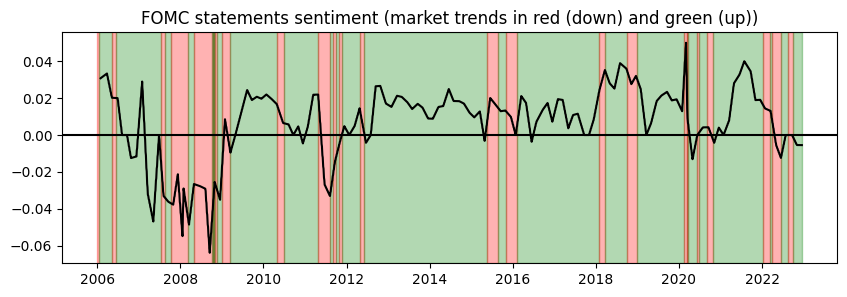

In [161]:
plot_shaded_trends(df_merge['sentiment'].interpolate())
plt.title('FOMC statements sentiment (market trends in red (down) and green (up))')

Text(0.5, 1.0, 'FOMC statements negative sentiment (market trends in red (down) and green (up))')

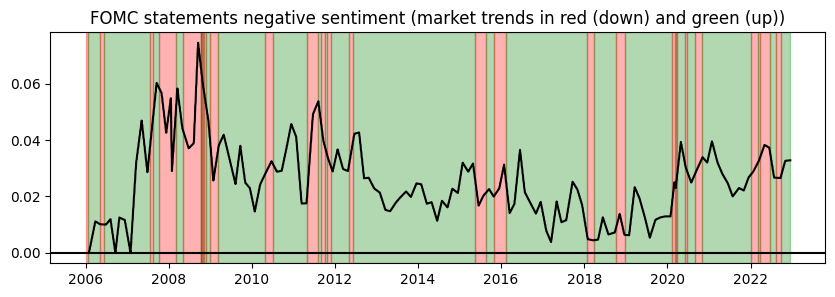

In [162]:
plot_shaded_trends(df_merge['neg_sentiment'].interpolate())
plt.title('FOMC statements negative sentiment (market trends in red (down) and green (up))')

Text(0.5, 1.0, 'FOMC statements positive sentiment (market trends in red (down) and green (up))')

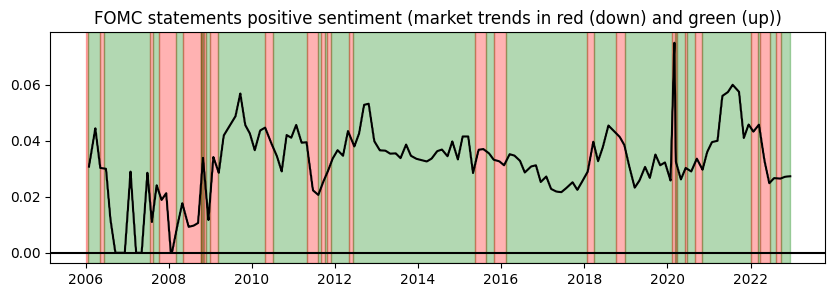

In [163]:
plot_shaded_trends(df_merge['pos_sentiment'].interpolate())
plt.title('FOMC statements positive sentiment (market trends in red (down) and green (up))')

Text(0.5, 1.0, 'FOMC statements uncertainty (market trends in red (down) and green (up))')

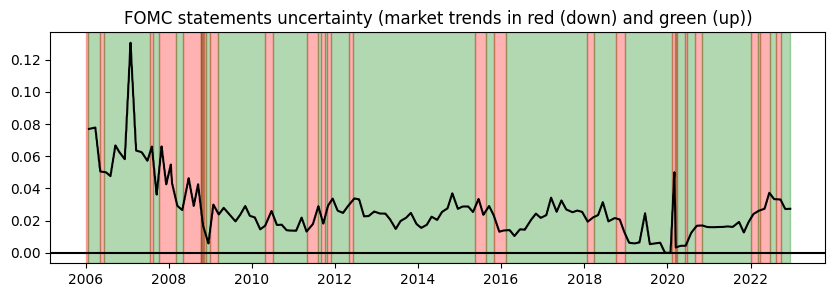

In [164]:
plot_shaded_trends(df_merge['uncertainty'].interpolate())
plt.title('FOMC statements uncertainty (market trends in red (down) and green (up))')

Text(0.5, 1.0, 'FOMC statements disagreement (market trends in red (down) and green (up))')

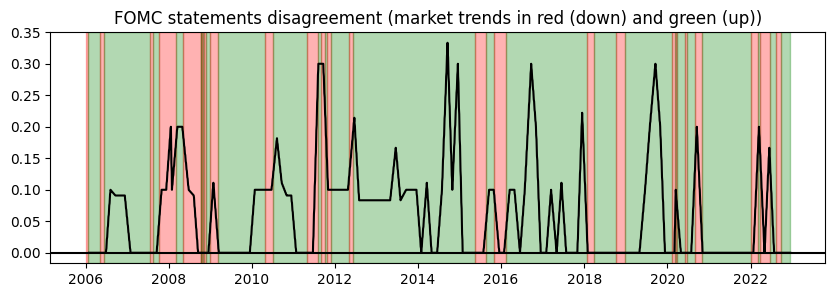

In [165]:
plot_shaded_trends(df_merge['disagreement_ratio'].interpolate())
plt.title('FOMC statements disagreement (market trends in red (down) and green (up))')

In [166]:
#calculate the average sentiment of FOMC statements per market segment
for i in range(0,len(segments.segments)):
    df_sub = df_merge[(df_merge.index>=segments.segments['date_1'][i]) & (df_merge.index<segments.segments['date_2'][i])]
    segments.segments['statements_resulting'][i] = np.nanmean(df_sub['sentiment'])

In [167]:
segments.segments.head()

,date_1,date_2,value_1,value_2,delta_t,delta_v,num_positive_statements,num_negative_statements,statements_resulting
0,2006-01-02,2006-01-20,10717.50,10667.39,18 days,-50.11,0,0,NaN
1,2006-01-20,2006-05-10,10667.39,11642.65,110 days,975.26,0,0,0.032051
2,2006-05-10,2006-06-13,11642.65,10706.14,34 days,-936.51,0,0,0.020202
3,2006-06-13,2007-07-19,10706.14,14000.41,401 days,3294.27,0,0,-0.005974
4,2007-07-19,2007-08-16,14000.41,12845.78,28 days,-1154.63,0,0,-0.032967


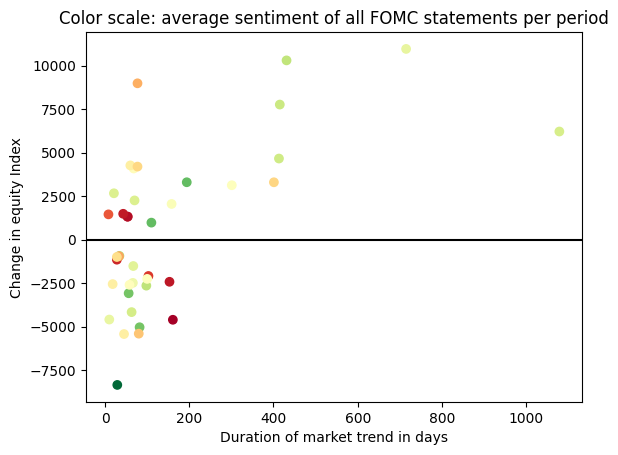

In [168]:
plt.scatter(segments.segments["delta_t"].dt.days, segments.segments["delta_v"], c=segments.segments["statements_resulting"], cmap='RdYlGn')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.ylabel('Change in equity Index')
plt.xlabel('Duration of market trend in days')
plt.title('Color scale: average sentiment of all FOMC statements per period')

plt.show()

In [169]:
print('average sentimentn in positive market ennvironemnts is: ', \
      round(np.nanmean(segments.segments[segments.segments['delta_v']>0]['statements_resulting']),5))

print('average sentimentn in negative market ennvironemnts is: ', \
      round(np.nanmean(segments.segments[segments.segments['delta_v']<0]['statements_resulting']),5))

average sentimentn in positive market ennvironemnts is:  0.00109
average sentimentn in negative market ennvironemnts is:  0.00176


# sandbox for downloading statements

In [83]:
# last: 'monetary20221214a'
# first: 'monetary20060131a'

url = 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20221102a.htm'
request_site = Request(url, headers={"User-Agent": "Mozilla/5.0"})
webpage = urlopen(request_site).read()

parsed_html = BeautifulSoup(webpage, "html.parser")
text = parsed_html.body.find(attrs={'class':'col-xs-12 col-sm-8 col-md-8'})

paragraphs = text.find_all('p')    
paragraphs = [pa.text for pa in paragraphs]

voting_for = [i for i, p in enumerate(paragraphs) if 'Voting for' in p]
voting_against = [i for i, p in enumerate(paragraphs) if 'Voting against' in p]

if len(voting_for)==0 and len(voting_against)==0:
    paragraph = ''
    voting_p = ''
elif len(voting_against)==0:
    paragraph = ' '.join(paragraphs[0:voting_for[0]])
    voting_p = paragraphs[voting_for[0]]
elif voting_for[0] == voting_against[0]:
    paragraph = ' '.join(paragraphs[0:voting_for[0]])
    voting_p = paragraphs[voting_for[0]]
elif voting_for[0] < voting_against[0]:
    paragraph = ' '.join(paragraphs[0:voting_for[0]])
    voting_p = ' '.join(paragraphs[voting_for[0]:(voting_against[0]+1)])


In [84]:
voting_p

'Voting for the monetary policy action were Jerome H. Powell, Chair; John C. Williams, Vice Chair; Michael S. Barr; Michelle W. Bowman; Lael Brainard; James Bullard; Susan M. Collins; Lisa D. Cook; Esther L. George; Philip N. Jefferson; Loretta J. Mester; and Christopher J. Waller.'

In [85]:
paragraphs

['Recent indicators point to modest growth in spending and production. Job gains have been robust in recent months, and the unemployment rate has remained low. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher food and energy prices, and broader price pressures.',
 "Russia's war against Ukraine is causing tremendous human and economic hardship. The war and related events are creating additional upward pressure on inflation and are weighing on global economic activity. The Committee is highly attentive to inflation risks.",
 "The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to raise the target range for the federal funds rate to 3-3/4 to 4 percent. The Committee anticipates that ongoing increases in the target range will be appropriate in order to attain a stance of monetary policy that is sufficiently restrictive to return infla